In [1]:
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer)
from datasets import load_dataset, DatasetDict
from typing import List, Dict
import torch
import pandas as pd 
import re

In [2]:
model_path = 'huyhoangt2201/llama-3.2-1b-sql_finetuned_multitableJidouka2_1.0_977_records_mix_merged'
dataset_path = 'huyhoangt2201/contextawareJidouka_fixed'

dataset = load_dataset(dataset_path)

device = torch.device('cuda'if torch.cuda.is_available() else 'cpu')

model = AutoModelForCausalLM.from_pretrained(model_path, device_map='auto')
tokenizer = AutoTokenizer.from_pretrained(model_path)

(…)tput152_records_contextAware_english.csv:   0%|          | 0.00/78.8k [00:00<?, ?B/s]

(…)tput157_records_contextAware_english.csv:   0%|          | 0.00/66.6k [00:00<?, ?B/s]

(…)d_time_department_dcgroup_vietnamese.csv:   0%|          | 0.00/151k [00:00<?, ?B/s]

(…)ixed_time_department_dcgroup_english.csv:   0%|          | 0.00/135k [00:00<?, ?B/s]

(…)t296_records_contextAware_vietnamese.csv:   0%|          | 0.00/197k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/977 [00:00<?, ? examples/s]

config.json:   0%|          | 0.00/928 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.47G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [16]:
# prompt_template = """You are an SQL query assistant. Based on schema and conversation history, which contains previous question, sql query, and schema-linking below, generate an SQL query to retrieve the relevant information for the user. If the user’s question is unrelated to the table, respond naturally in user's language.
# Schema:
# +Table Job, columns=[Id: int, Job_name: nvarchar(255)]
# +Table Department, columns=[Id: int, Department_name: nvarchar(255)]
# +Table Author, columns=[Id: int, Author_name: nvarchar(255)]
# +Table Tool, columns=[Id: int, Tool_name: nvarchar(255)]
# +Table Jidouka, columns=[Id: int, Improve_name: nvarchar(255), Job_id: int, Department_id: int, Author_id, Description: text, Product_name: nvarchar(255), Time: int, Applications: int, Release_date: datetime, Other_info: text]
# +Table JidoukaTool, columns=[Jidouka_id int, Tool_id int]
# +Primary_keys=[Job.Id, Department.Id, Author.Id, Tool.Id, Jidouka,Id]
# +Foreign_keys=[Jidouka.Job_id=Job.Id, Jidouka.Department_id=Department.Id, Jidouka.Author_id=Author.Id, JidoukaTool.Jidouka_id=Jidouka.Id, JidoukaTool.Tool_id=Tool.Id]

# Conversation History: 
# User: List all the innovation that were created by DC2?
# SQL Query: SELECT Jidouka.Improve_name FROM Jidouka JOIN Department ON Jidouka.Department_id = Department.Id WHERE Department.Department_name LIKE LOWER('%DC2%');
# Schema linking(Format: [Tables, Columns, Foreign keys, Possible cell values]) : {Tables: [Jidouka, Department], Columns: [Jidouka.Improve_name, Jidouka.Department_id, Department.Id, Department.Department_name], Possible cell values=[DC2]}
# """

In [ ]:
#improvementContent

In [19]:
system_prompt = """You are an SQL query assistant. Based on schema below, generate an SQL query to retrieve the relevant information for the user. If the user’s question is unrelated to the table, respond naturally in user's language.

Schema:
+Table Author, columns=[AuthorId: int, AuthorName: nvarchar(255)]
+Table Department, columns=[DepartmentId: int, DepartmentName: nvarchar(255)]
+Table GroupDC, columns=[GroupDCId: int, DepartmentId: int, GroupDCName nvarchar(255)]
+Table Job, columns=[JobId: int, JobName: nvarchar(255)]
+Table Tool, columns=[ToolId: int, ToolName: nvarchar(255), ToolDescription: text]
+Table Jidouka, columns=[JidoukaId: bigint, ProductApply: nvarchar(255), ImprovementName: nvarchar(255), SoftwareUsing: nvarchar(255), Description: nvarchar(255), Video: text, DetailDocument: text, TotalJobApplied: int, TotalTimeSaved: int, DateCreate: datetime, JobId: int, AuthorId: int, DepartmentId: int, GroupDCId: int]
+Table JidoukaTool, columns=[JidoukaId: bigint, ToolId: int]
+Primary_keys=[Author.AuthorId, Department.DepartmentId, GroupDC.GroupDCId, Job.JobId, Tool.ToolId, Jidouka.JidoukaId]
+Foreign_keys=[GroupDC.DepartmentId=Department.DepartmentId, Jidouka.JobId=Job.JobId, Jidouka.AuthorId=Author.AuthorId, Jidouka.DepartmentId=Department.DepartmentId, Jidouka.GroupDCId=GroupDC.GroupDCId, JidoukaTool.JidoukaId=Jidouka.JidoukaId, JidoukaTool.ToolId=Tool.ToolId]
"""

In [3]:
system_prompt = """You are an SQL query assistant. Based on schema below, generate an SQL query to retrieve the relevant information for the user. If the user’s question is unrelated to the table, respond naturally in user's language.

Schema:
+Table Author, columns=[AuthorId: int, AuthorName: nvarchar(255)]
+Table Department, columns=[DepartmentId: int, DepartmentName: nvarchar(255)]
+Table GroupDC, columns=[GroupDCId: int, DepartmentId: int, GroupDCName nvarchar(255)]
+Table Job, columns=[JobId: int, JobName: nvarchar(255)]
+Table Tool, columns=[ToolId: int, ToolName: nvarchar(255), ToolDescription: text]
+Table Jidouka, columns=[JidoukaId: bigint, ProductApply: nvarchar(255), ImprovementName: nvarchar(255), SoftwareUsing: nvarchar(255), Description: nvarchar(255), Video: text, DetailDocument: text, TotalJobApplied: int, TotalTimeSaved: int, DateCreate: datetime, JobId: int, AuthorId: int, DepartmentId: int, GroupDCId: int]
+Table JidoukaTool, columns=[JidoukaId: bigint, ToolId: int]
+Primary_keys=[Author.AuthorId, Department.DepartmentId, GroupDC.GroupDCId, Job.JobId, Tool.ToolId, Jidouka.JidoukaId]
+Foreign_keys=[GroupDC.DepartmentId=Department.DepartmentId, Jidouka.JobId=Job.JobId, Jidouka.AuthorId=Author.AuthorId, Jidouka.DepartmentId=Department.DepartmentId, Jidouka.GroupDCId=GroupDC.GroupDCId, JidoukaTool.JidoukaId=Jidouka.JidoukaId, JidoukaTool.ToolId=Tool.ToolId]
"""

In [6]:
dataset['train']

Dataset({
    features: ['previous_question', 'previous_answer', 'schema_linking', 'question', 'answer'],
    num_rows: 146
})

In [4]:
%%time
eot = "<|eot_id|>"
eot_id = tokenizer.convert_tokens_to_ids(eot)
tokenizer.pad_token = eot
tokenizer.pad_token_id = eot_id

num_true = 0
wrong_answer = {'question':[], 'right_answer':[], 'bot_response':[]}
for i in range(len(dataset['train']['previous_question'])):
    messages = [
        {'role':'system',
        'content':system_prompt},
        {'role':'user',
        'content':dataset['train']['previous_question'][i]}
    ]

    chat = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    inputs = tokenizer(chat, padding=True, truncation=True, return_tensors='pt').to(device)
    outputs = model.generate(inputs['input_ids'],
                            attention_mask=inputs['attention_mask'],
                            max_new_tokens=256,
                             temperature=0.1,
                             do_sample=True,
                             top_p=0.1).to('cuda')
    response = tokenizer.decode(outputs[0])
    response = response.split('<|start_header_id|>assistant<|end_header_id|>')
    response = response[1].strip()[:-10]

    if response.lower() == dataset['train']['previous_answer'][i].lower():
        num_true += 1
    elif not response.startswith('SELECT') and not dataset['train']['previous_answer'][i].startswith('SELECT'):
        num_true += 1
    else:
        wrong_answer['question'].append(dataset['train']['previous_question'][i])
        wrong_answer['right_answer'].append(dataset['train']['previous_answer'][i])
        wrong_answer['bot_response'].append(response)

import pandas as pd
wrong_answer_df = pd.DataFrame(wrong_answer)
print(f"Num true: {num_true} on total {len(dataset['train']['previous_question'])} questions")
print(f"Accuracy: {100*(num_true)/len(dataset['train']['previous_question'])}%")

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.
Setting `pa

Num true: 494 on total 977 questions
Accuracy: 50.562947799385874%
CPU times: user 25min 43s, sys: 5.16 s, total: 25min 48s
Wall time: 25min 59s


contextAware1.0:
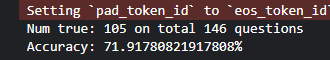

In [5]:
wrong_answer_df.to_csv('multitableJidouka2.0_977.csv', index=False)

In [8]:
dataset['train']['schema_linking'][1]

'{Tables: [Tool, JidoukaTool], Columns: [Tool.ToolName, JidoukaTool.JidoukaId, JidoukaTool.ToolId], Foreign keys: [JidoukaTool.ToolId=Tool.ToolId], Possible cell values: [789]}'

In [20]:
# previous_question = "which department that contributed to innovation?"
# previous_answer = "SELECT DepartmentName FROM Department JOIN Jidouka ON Department.DepartmentId=Jidouka.DepartmentId"
# schema_linking  = "{Tables: [Department, Jidouka], Columns: [Department.DepartmentName, Deparment.DepartmentId, Jidouka.DepartmentId], Foreign keys: [Department.DepartmentId=Jidouka.DepartmentId], Possible cell values: []}"
# question = "Show id of these departments"

previous_question = ''
previous_answer = ""
schema_linking = ""
question = "show id of department that have more than 3 innovation"


eot = "<|eot_id|>"
eot_id = tokenizer.convert_tokens_to_ids(eot)
tokenizer.pad_token = eot
tokenizer.pad_token_id = eot_id

messages = [
    {'role':'system',
    'content':system_prompt.format(previous_question=previous_question,previous_answer=previous_answer,schema_linking=schema_linking)},
    {'role':'user',
    'content':question}
]

chat = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
inputs = tokenizer(chat, padding=True, truncation=True, return_tensors='pt').to(device)
outputs = model.generate(inputs['input_ids'],
                        attention_mask=inputs['attention_mask'],
                        max_new_tokens=256,
                         temperature=0.1,
                         do_sample=True,
                         top_p=0.1).to('cuda')
response = tokenizer.decode(outputs[0])
response = response.split('<|start_header_id|>assistant<|end_header_id|>')
response = response[1].strip()[:-10]

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [21]:
response

'SELECT DISTINCT Department.DepartmentId FROM Department JOIN Jidouka ON Department.DepartmentId = Jidouka.DepartmentId GROUP BY Department.DepartmentId HAVING COUNT(Jidouka.JobName) > 3;'

In [ ]:
# 3. Chatbot Class
class ContextAwareChatbot:
    def __init__(self,max_history: int = 1):
        self.model = model
        self.tokenizer = tokenizer
        self.max_history = max_history
        self.conversation_history: List[Dict[str, str]] = []
    def _build_prompt(self) -> str:
        # Build context from history
        history_text = ""
        for exchange in self.conversation_history[-self.max_history:]:
            history_text += f"Previous user question: {exchange['previous_question']}\nPrevious answer: {exchange['previous_answer']}\nSchema linking: {exchange['schema_linking']}\n"
        # Create the full prompt with context
        system_prompt = f"""You are an SQL query assistant. Based on schema and context below, generate an SQL query to retrieve the relevant information for the user. If the user’s question is unrelated to the table, respond naturally in user's language.
        
        Schema:
        +Table Author, columns=[AuthorId: int, AuthorName: nvarchar(255), DepartmentId: int, GroupDCId: int]
        +Table Department, columns=[DepartmentId: int, DepartmentName: nvarchar(255)]
        +Table GroupDC, columns=[GroupDCId: int, DepartmentId: int, GroupDCName nvarchar(255)]
        +Table Job, columns=[JobId: int, JobName: nvarchar(255)]
        +Table Tool, columns=[ToolId: int, ToolName: nvarchar(255), ToolDescription: text]
        +Table Jidouka, columns=[JidoukaId: bigint, ProductApply: nvarchar(255), ImprovementName: nvarchar(255), SoftwareUsing: nvarchar(255), Description: nvarchar(255), Video: text, DetailDocument: text, TotalJobApplied: int, TotalTimeSaved: int, DateCreate: datetime, JobId: int, AuthorId: int, DepartmentId: int, GroupDCId: int]
        +Table JidoukaTool, columns=[JidoukaId: bigint, ToolId: int]
        +Primary_keys=[Author.AuthorId, Department.DepartmentId, GroupDC.GroupDCId, Job.JobId, Tool.ToolId, Jidouka.JidoukaId]
        +Foreign_keys=[GroupDC.DepartmentId=Department.DepartmentId, Jidouka.JobId=Job.JobId, Jidouka.AuthorId=Author.AuthorId, Jidouka.DepartmentId=Department.DepartmentId, Jidouka.GroupDCId=GroupDC.GroupDCId, JidoukaTool.JidoukaId=Jidouka.JidoukaId, JidoukaTool.ToolId=Tool.ToolId, Author.DepartmentId=Department.DepartmentId, Author.GroupDCId=GroupDC.GroupDCId]]

        Here are some examples about data in some column in database, based on that to make more concise SQL query:
        -Department.DepartmentName: [DC1, DC2, DC3, DC4, DC5, AS, PS]
        -GroupDC.GroupDCName: [ABC, XYZ, YHK]
        Context:
        {history_text}
        
        """
        return system_prompt
    
    def _clean_response(self, response: str) -> str:
        # Clean up the generated response
        response = response.split("Assistant:")[-1].strip()
        # Stop at any new "Human:" or "Assistant:" markers
        if "Human:" in response:
            response = response.split("Human:")[0].strip()
        return response

    def _extract_schema_linking(self, sql_query: str) -> str:
        # Placeholder lists
        tables = set()
        columns = set()
        foreign_keys = set()
        possible_cell_values = set()
        
        # Regex patterns
        table_pattern = re.compile(r"(?:FROM|JOIN)\s+([\w]+)", re.IGNORECASE)
        column_pattern = re.compile(r"SELECT\s+(.*?)\s+FROM", re.IGNORECASE)
        foreign_key_pattern = re.compile(r"ON\s+([\w.]+)\s*=\s*([\w.]+)", re.IGNORECASE)
        value_pattern = re.compile(r"WHERE\s+[\w.]+\s*(?:=|LIKE)\s*(LOWER\(['\"]?%?([\w\s]+)%?['\"]?\))?", re.IGNORECASE)
        in_values_pattern = re.compile(r"IN\s*\((.+?)\)", re.IGNORECASE)
        
        # Extract tables
        tables.update(table_pattern.findall(sql_query))
        
        # Extract columns
        column_match = column_pattern.search(sql_query)
        if column_match:
            columns_list = column_match.group(1).split(',')
            columns.update(col.strip() for col in columns_list)
        
        # Extract foreign keys
        foreign_key_matches = foreign_key_pattern.findall(sql_query)
        for fk_left, fk_right in foreign_key_matches:
            foreign_keys.add(f"{fk_left.strip()} = {fk_right.strip()}")
        
        # Extract possible cell values from WHERE conditions
        value_match = value_pattern.findall(sql_query)
        if value_match:
            for _, val in value_match:
                if val:  # If there's a valid value inside LOWER or LIKE
                    cleaned_value = val.strip()
                    possible_cell_values.add(cleaned_value)
        
        # Extract possible cell values from IN clauses
        in_values_match = in_values_pattern.findall(sql_query)
        if in_values_match:
            for values in in_values_match:
                values_list = values.split(',')
                possible_cell_values.update(val.strip().strip("'\"") for val in values_list)
        
        # Convert to sorted lists for consistency
        return f"""
            Tables: {sorted(tables)},
            Columns: {sorted(columns)},
            Foreign keys: {sorted(foreign_keys)},
            Possible cell values: {sorted(possible_cell_values)}"""
            
    def chat(self, user_input: str) -> str:
        # Generate the contextualized prompt
        prompt = self._build_prompt()
        
#         # Generate response
#         response = self.pipeline(
#             prompt,
#             return_full_text=False,
#             clean_up_tokenization_spaces=True
#         )[0]['generated_text']
        
#         # Clean the response
#         cleaned_response = self._clean_response(response)
        eot = "<|eot_id|>"
        eot_id = self.tokenizer.convert_tokens_to_ids(eot)
        self.tokenizer.pad_token = eot
        self.tokenizer.pad_token_id = eot_id
        messages =[
            {'role':'system',
             'content':prompt}
            ,
            {'role':'user',
             'content':user_input}
        ]
        
        chat = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer(chat, padding=True, truncation=True, return_tensors='pt').to('cuda')
        outputs = self.model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'],max_new_tokens=256, temperature=0.1, do_sample=True, top_p=0.1).to('cuda')
        bot_response = self.tokenizer.decode(outputs[0])
        bot_response = bot_response.split('<|start_header_id|>assistant<|end_header_id|>')
        bot_response = bot_response[1].strip()[:-10]
        # Update conversation history
        self.conversation_history.append({
            'previous_question': user_input,
            'previous_answer': bot_response,
            'schema_linking': self._extract_schema_linking(bot_response)
        })
        
        return bot_response
    
    def get_history(self) -> List[Dict[str, str]]:
        return self.conversation_history
    
    def clear_history(self):
        self.conversation_history = []

# 4. Create chatbot instance
chatbot = ContextAwareChatbot()

# 5. Example usage function
def chat_session():
    print("Chatbot initialized. Type 'exit' to end the conversation, 'clear' to clear history.")
    
    while True:
        user_input = input("\nYou: ").strip()
        
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        elif user_input.lower() == 'clear':
            chatbot.clear_history()
            print("Conversation history cleared!")
            continue
            
        response = chatbot.chat(user_input)
        print(f"\nAssistant: {response}")

# 6. Example of how to use
if __name__ == "__main__":
    chat_session()

Chatbot initialized. Type 'exit' to end the conversation, 'clear' to clear history.



You:  có bao nhiêu người thuộc Group Dc2


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Assistant: SELECT COUNT(DISTINCT Author.AuthorId) FROM Author JOIN GroupDC ON Author.AuthorId = GroupDC.AuthorId WHERE GroupDC.GroupDCName = 'DC2';


In [ ]:
# 3. Chatbot Class
class ContextAwareChatbot:
    def __init__(self,max_history: int = 0):
        self.model = model
        self.tokenizer = tokenizer
        self.max_history = max_history
        self.conversation_history: List[Dict[str, str]] = []
    def _build_prompt(self) -> str:
        # Build context from history
        history_text = ""
        for exchange in self.conversation_history[-self.max_history:]:
            history_text += f"Previous user question: {exchange['previous_question']}\nPrevious answer: {exchange['previous_answer']}\n"
        # Create the full prompt with context
        system_prompt = f"""You are an SQL query assistant. Based on schema and context below, generate an SQL query to retrieve the relevant information for the user. If the user’s question is unrelated to the table, respond naturally in user's language.
        
        Schema:
        +Table Author, columns=[AuthorId: int, AuthorName: nvarchar(255), DepartmentId: int, GroupDCId: int]
        +Table Department, columns=[DepartmentId: int, DepartmentName: nvarchar(255)]
        +Table GroupDC, columns=[GroupDCId: int, DepartmentId: int, GroupDCName nvarchar(255)]
        +Table Job, columns=[JobId: int, JobName: nvarchar(255)]
        +Table Tool, columns=[ToolId: int, ToolName: nvarchar(255), ToolDescription: text]
        +Table Jidouka, columns=[JidoukaId: bigint, ProductApply: nvarchar(255), ImprovementName: nvarchar(255), SoftwareUsing: nvarchar(255), Description: nvarchar(255), Video: text, DetailDocument: text, TotalJobApplied: int, TotalTimeSaved: int, DateCreate: datetime, JobId: int, AuthorId: int, DepartmentId: int, GroupDCId: int]
        +Table JidoukaTool, columns=[JidoukaId: bigint, ToolId: int]
        +Primary_keys=[Author.AuthorId, Department.DepartmentId, GroupDC.GroupDCId, Job.JobId, Tool.ToolId, Jidouka.JidoukaId]
        +Foreign_keys=[GroupDC.DepartmentId=Department.DepartmentId, Jidouka.JobId=Job.JobId, Jidouka.AuthorId=Author.AuthorId, Jidouka.DepartmentId=Department.DepartmentId, Jidouka.GroupDCId=GroupDC.GroupDCId, JidoukaTool.JidoukaId=Jidouka.JidoukaId, JidoukaTool.ToolId=Tool.ToolId, Author.DepartmentId=Department.DepartmentId, Author.GroupDCId=GroupDC.GroupDCId]]

        Here are some examples about data in some column in database, based on that to make more concise SQL query:
        -Department.DepartmentName: DC1, DC2, DC3, DC4, DC5, AS, PS
        -GroupDC.GroupDCName: ABC, XYZ, YHK
        Context:
        {history_text}
        
        """
        return system_prompt
    
    def _clean_response(self, response: str) -> str:
        # Clean up the generated response
        response = response.split("Assistant:")[-1].strip()
        # Stop at any new "Human:" or "Assistant:" markers
        if "Human:" in response:
            response = response.split("Human:")[0].strip()
        return response

    def _extract_schema_linking(self, sql_query: str) -> str:
        # Placeholder lists
        tables = set()
        columns = set()
        foreign_keys = set()
        possible_cell_values = set()
        
        # Regex patterns
        table_pattern = re.compile(r"(?:FROM|JOIN)\s+([\w]+)", re.IGNORECASE)
        column_pattern = re.compile(r"SELECT\s+(.*?)\s+FROM", re.IGNORECASE)
        foreign_key_pattern = re.compile(r"ON\s+([\w.]+)\s*=\s*([\w.]+)", re.IGNORECASE)
        value_pattern = re.compile(r"WHERE\s+[\w.]+\s*(?:=|LIKE)\s*(LOWER\(['\"]?%?([\w\s]+)%?['\"]?\))?", re.IGNORECASE)
        in_values_pattern = re.compile(r"IN\s*\((.+?)\)", re.IGNORECASE)
        
        # Extract tables
        tables.update(table_pattern.findall(sql_query))
        
        # Extract columns
        column_match = column_pattern.search(sql_query)
        if column_match:
            columns_list = column_match.group(1).split(',')
            columns.update(col.strip() for col in columns_list)
        
        # Extract foreign keys
        foreign_key_matches = foreign_key_pattern.findall(sql_query)
        for fk_left, fk_right in foreign_key_matches:
            foreign_keys.add(f"{fk_left.strip()} = {fk_right.strip()}")
        
        # Extract possible cell values from WHERE conditions
        value_match = value_pattern.findall(sql_query)
        if value_match:
            for _, val in value_match:
                if val:  # If there's a valid value inside LOWER or LIKE
                    cleaned_value = val.strip()
                    possible_cell_values.add(cleaned_value)
        
        # Extract possible cell values from IN clauses
        in_values_match = in_values_pattern.findall(sql_query)
        if in_values_match:
            for values in in_values_match:
                values_list = values.split(',')
                possible_cell_values.update(val.strip().strip("'\"") for val in values_list)
        
        # Convert to sorted lists for consistency
        return f"""
            Tables: {sorted(tables)},
            Columns: {sorted(columns)},
            Foreign keys: {sorted(foreign_keys)},
            Possible cell values: {sorted(possible_cell_values)}"""
            
    def chat(self, user_input: str) -> str:
        # Generate the contextualized prompt
        prompt = self._build_prompt()
        
#         # Generate response
#         response = self.pipeline(
#             prompt,
#             return_full_text=False,
#             clean_up_tokenization_spaces=True
#         )[0]['generated_text']
        
#         # Clean the response
#         cleaned_response = self._clean_response(response)
        eot = "<|eot_id|>"
        eot_id = self.tokenizer.convert_tokens_to_ids(eot)
        self.tokenizer.pad_token = eot
        self.tokenizer.pad_token_id = eot_id
        messages =[
            {'role':'system',
             'content':prompt}
            ,
            {'role':'user',
             'content':user_input}
        ]
        
        chat = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        inputs = self.tokenizer(chat, padding=True, truncation=True, return_tensors='pt').to('cuda')
        outputs = self.model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'],max_new_tokens=512, temperature=0.1, do_sample=True, top_p=0.1).to('cuda')
        bot_response = self.tokenizer.decode(outputs[0])
        bot_response = bot_response.split('<|start_header_id|>assistant<|end_header_id|>')
        bot_response = bot_response[1].strip()[:-10]
        # Update conversation history
        self.conversation_history.append({
            'previous_question': user_input,
            'previous_answer': bot_response
        })
        
        return bot_response
    
    def get_history(self) -> List[Dict[str, str]]:
        return self.conversation_history
    
    def clear_history(self):
        self.conversation_history = []

# 4. Create chatbot instance
chatbot = ContextAwareChatbot()

# 5. Example usage function
def chat_session():
    print("Chatbot initialized. Type 'exit' to end the conversation, 'clear' to clear history.")
    
    while True:
        user_input = input("\nYou: ").strip()
        
        if user_input.lower() == 'exit':
            print("Goodbye!")
            break
        elif user_input.lower() == 'clear':
            chatbot.clear_history()
            print("Conversation history cleared!")
            continue
            
        response = chatbot.chat(user_input)
        print(f"\nAssistant: {response}")

# 6. Example of how to use
if __name__ == "__main__":
    chat_session()

Chatbot initialized. Type 'exit' to end the conversation, 'clear' to clear history.



You:  Which innovations are linked to the MCV group in DC1?


Setting `pad_token_id` to `eos_token_id`:None for open-end generation.



Assistant: SELECT Jidouka.ImprovementName FROM Jidouka JOIN GroupDC ON Jidouka.GroupDCId = GroupDC.GroupDCId JOIN Department ON Jidouka.DepartmentId = Department.DepartmentId WHERE GroupDC.GroupDCName LIKE LOWER('%ABC%') AND Department.DepartmentName LIKE LOWER('%DC1%');
